#**Overfiting and Underfiting**

* Learning how to deal with overfitting is important. Although it's often possible to achieve high accuracy on the training set, what we really want is to develop models that generalize well to a testing set (or data they haven't seen before).
* The opposite of overfitting is underfitting. Underfitting occurs when there is still room for improvement on the test data. This can happen for a number of reasons: If the model is not powerful enough, is over-regularized, or has simply not been trained long enough. This means the network has not learned the relevant patterns in the training data.
* If you train for too long though, the model will start to overfit and learn patterns from the training data that don't generalize to the test data. We need to strike a balance. Understanding how to train for an appropriate number of epochs as we'll explore below is a useful skill.
* To prevent overfitting, the best solution is to use more complete training data. The dataset should cover the full range of inputs that the model is expected to handle. Additional data may only be useful if it covers new and and interesting cases.
* A model trained on more complete data will naturally generalize better. When that is no longer possible, the next best solution is to use techniques like regularization. These place constraints on the quantity and type of information your model can store. If a network can only afford to memorize a small number of patterns, the optimization process will force it to focus on the most prominent patterns, which have a better chance of generalizing well.
#####**Let's start**


In [1]:
# overfitAndUnderfit.ipynb
!pip install -q git+https://github.com/tensorflow/docs
import tensorflow as tf
if tf.__version__ != '2.0.0':
  !pip install tensorflow==2.0.0
from tensorflow.keras import layers
from tensorflow.keras import regularizers
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots
from IPython import display
from matplotlib import pyplot as plt
import numpy as np
import pathlib
import shutil
import tempfile
!pip install -U tensorboard >piplog 2>&1
print("Your tf version : ",tf.__version__)


Your tf version :  2.0.0


In [2]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)
tempfile.mkdtemp()

'/tmp/tmpdzo5f59z'

##**The Higgs Dataset**
It contains 11 000 000 examples, each with 28 features, and a binary class label.

In [3]:
gz = tf.keras.utils.get_file('HIGGS.csv.gz', 'https://archive.ics.uci.edu/ml/machine-learning-databases/00280/HIGGS.csv.gz')

2816409600/2816407858 [==============================] - 63s 0us/step


In [0]:
FEATURES = 28

The tf.data.experimental.CsvDataset class can be used to read csv records directly from a gzip file with no intermediate decompression step.

In [0]:
ds = tf.data.experimental.CsvDataset(gz, [float(), ]*(FEATURES+1), compression_type="GZIP")

That csv reader class returns a list of scalars for each record. The following function repacks that list of scalars into a (feature_vector, label) pair.

In [0]:
def packRow(*row):
  label = row[0]
  features = tf.stack(row[1:], 1)
  return features , label

TensorFlow is most efficient when operating on large batches of data.

So instead of repacking each row individually make a new Dataset that takes batches of 10000-examples, applies the pack_row function to each batch, and then splits the batches back up into individual records:

In [0]:
packedDs = ds.batch(10000).map(packRow).unbatch()

Have a look at some of the records from this new packed_ds.

The features are not perfectly normalized, but this is sufficient for this tutorial.

tf.Tensor(
[ 0.8692932  -0.6350818   0.22569026  0.32747006 -0.6899932   0.75420225
 -0.24857314 -1.0920639   0.          1.3749921  -0.6536742   0.9303491
  1.1074361   1.1389043  -1.5781983  -1.0469854   0.          0.65792954
 -0.01045457 -0.04576717  3.1019614   1.35376     0.9795631   0.97807616
  0.92000484  0.72165745  0.98875093  0.87667835], shape=(28,), dtype=float32)


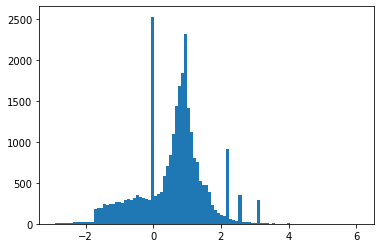

In [8]:
for features , label in packedDs.batch(1000).take(1):
  print(features[0])
  plt.hist(features.numpy().flatten(), bins=101)
  

Since the data set is too large, let's use only the first 1000 samples for verification and the next 10,000 for training.

In [0]:
N_VALIDATION = int(1e3) # 1000
N_TRAIN = int(1e4)      #10000
BUFFER_SIZE = int(1e4)
BATCH_SIZE = 500
STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE

* The Dataset.skip and Dataset.take methods make this easy.

* At the same time, let's use the Dataset.cache method to make sure that the installer does not need to reread the data in the file in each circuit.

In [10]:
validateDs = packedDs.take(N_VALIDATION).cache()
trainDs = packedDs.skip(N_VALIDATION).take(N_TRAIN).cache()
trainDs

<CacheDataset shapes: ((28,), ()), types: (tf.float32, tf.float32)>

These data sets give individual examples. Use the .batch method to create groups of appropriate size for training. Before grouping, remember the .shuffle  and .repeat commands.

In [0]:
validateDs = validateDs.batch(BATCH_SIZE)
trainDs = trainDs.shuffle(BUFFER_SIZE).repeat().batch(BATCH_SIZE)

####**Demonstrate overfitting**
* The simplest way to prevent overfitting is to start with a small model: A model with a small number of learnable parameters (which is determined by the number of layers and the number of units per layer). In deep learning, the number of learnable parameters in a model is often referred to as the model's "capacity".
* Intuitively, a model with more parameters will have more "memorization capacity" and therefore will be able to easily learn a perfect dictionary-like mapping between training samples and their targets, a mapping without any generalization power, but this would be useless when making predictions on previously unseen data.
* Deep learning models tend to be good at fitting to the training data, but the real challenge is generalization, not fitting.
* On the other hand, if the network has limited memorization resources, it will not be able to learn the mapping as easily. To minimize its loss, it will have to learn compressed representations that have more predictive power. At the same time, if you make your model too small, it will have difficulty fitting to the training data. There is a balance between "too much capacity" and "not enough capacity".
* Unfortunately, there is no magical formula to determine the right size or architecture of your model (in terms of the number of layers, or the right size for each layer). You will have to experiment using a series of different architectures.
* To find an appropriate model size, it's best to start with relatively few layers and parameters, then begin increasing the size of the layers or adding new layers until you see diminishing returns on the validation loss.
* Start with a simple model using only layers.Dense as a baseline, then create larger versions, and compare them.

#**Training Prodecure**
Many models train better if you gradually reduce the learning rate during training. Use **optimizers.schedules** to reduce the learning rate over time

In [0]:
lrSchedule = tf.keras.optimizers.schedules.InverseTimeDecay( 
    0.001, # firstLearningRate
    decay_steps=STEPS_PER_EPOCH*1000,
    decay_rate=1,
    staircase=False) # decay like staircase (cornered graph)

The code above sets a schedules.InverseTimeDecay to hyperbolically decrease the learning rate to 1/2 of the base rate at 1000 epochs, 1/3 at 2000 epochs and so on.

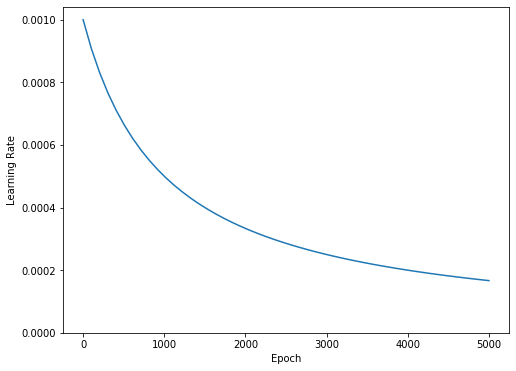

In [13]:
step = np.linspace(0, 100000) # np.linspace(start, stop, num=50, ...)  Divides the given range into equal parts
lr = lrSchedule(step) 
plt.figure(figsize=(8,6))
plt.plot(step/STEPS_PER_EPOCH, lr)
plt.ylim([0, max(plt.ylim())]) # lower and higher value for y axis
plt.xlabel('Epoch')
_ = plt.ylabel('Learning Rate')

* The training for this tutorial runs for many short epochs. To reduce the logging noise use the tfdocs.EpochDots which simply a . for each epoch and, and a full set of metrics every 100 epochs.
* Next include callbacks.EarlyStopping to avoid long and unnecessary training times. Note that this callback is set to monitor the val_binary_crossentropy, not the val_loss. This difference will be important later.
* Use **callbacks.TensorBoard** to generate TensorBoard logs for the training.

In [0]:
def getCallBacks(name):
  return[
    tfdocs.modeling.EpochDots(),
    tf.keras.callbacks.EarlyStopping(monitor='val_binary_crossentropy', patience=200),
    tf.keras.callbacks.TensorBoard(logdir/name),
  ]
def getOptimizer():
  return tf.keras.optimizers.Adam(lrSchedule)

Similarly each model will use the same Model.compile and Model.fit settings.

In [0]:
def compileAndFit(model, name, optimizer=None, maxEpochs=2000):
  if optimizer is None:
    optimizer = getOptimizer()
  model.compile(optimizer=optimizer,
                loss='binary_crossentropy',
                metrics=['accuracy', 'binary_crossentropy'])
  model.summary()

  history = model.fit(
      trainDs,
      steps_per_epoch=STEPS_PER_EPOCH,
      epochs=maxEpochs,
      validation_data=validateDs,
      callbacks=getCallBacks(name),
      verbose=0)
  return history

#**Tiny Model**
Let's start by educating a linear model

In [0]:
tinyModel = tf.keras.Sequential([
      layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
      layers.Dense(1, activation='sigmoid')
      ])

In [17]:
sizeHistories = {}
sizeHistories['Tiny'] = compileAndFit(tinyModel, 'sizes/Tiny')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                464       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 481
Trainable params: 481
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.5058,  binary_crossentropy:0.7581,  loss:0.7581,  val_accuracy:0.5040,  val_binary_crossentropy:0.7327,  val_loss:0.7327,  
....................................................................................................
Epoch: 100, accuracy:0.6483,  binary_crossentropy:0.6285,  loss:0.6285,  val_accuracy:0.6350,  val_binary_crossentropy:0.6299,  val_loss:0.6299,  
....................................................................................................
Epoch: 200, accuracy:0.66

Let's now check how the model did

(0.5, 0.7)

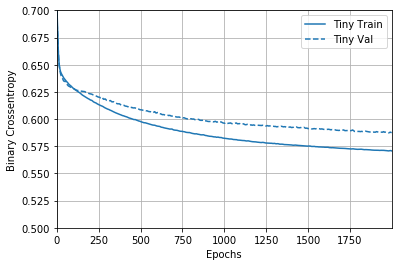

In [18]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'binary_crossentropy', smoothing_std=10)
plotter.plot(sizeHistories)
plt.ylim([0.5, 0.7])

#**Small Model**
* To see if you can beat the performance of the small model, progressively train some larger models.

* Try two hidden layers with 16 units each:

In [0]:
smallModel = tf.keras.Sequential([
    layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(16, activation='elu'),
    layers.Dense(1, activation='sigmoid')
])

In [20]:
sizeHistories['Small'] = compileAndFit(smallModel, 'sizes/Small')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 16)                464       
_________________________________________________________________
dense_3 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 17        
Total params: 753
Trainable params: 753
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.5061,  binary_crossentropy:0.7242,  loss:0.7242,  val_accuracy:0.4870,  val_binary_crossentropy:0.7151,  val_loss:0.7151,  
....................................................................................................
Epoch: 100, accuracy:0.6566,  binary_crossentropy:0.6191,  loss:0.6191,  val_accuracy:0.6600,  val_binary_crossentropy:0.6227,  val_loss:0.

#**Medium Model**
Now try 3 hidden layers with 64 units each.

In [0]:
mediumModel = tf.keras.Sequential([
    layers.Dense(64, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(64, activation='elu'),
    layers.Dense(64, activation='elu'),
    layers.Dense(1, activation='sigmoid')
])

And train the model using the same data

In [22]:
sizeHistories['Medium'] = compileAndFit(mediumModel, 'sizes/Medium')

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 64)                1856      
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_7 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 10,241
Trainable params: 10,241
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.5293,  binary_crossentropy:0.6958,  loss:0.6958,  val_accuracy:0.5410,  val_binary_crossentropy:0.6873,  val_loss:0.6873,  
....................................................................................................
E

#**Large Model**
* As an exercise, you can create an even larger model, and see how quickly it begins overfitting. 
* Next, let's add to this benchmark a network that has much more capacity, far more than the problem would warrant:

In [0]:
largeModel = tf.keras.Sequential([
    layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(1, activation='sigmoid')
])

In [24]:
sizeHistories['Large'] = compileAndFit(largeModel,'sizes/Large')

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 512)               14848     
_________________________________________________________________
dense_10 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_11 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_12 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 513       
Total params: 803,329
Trainable params: 803,329
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.5200,  binary_crossentropy:0.7942,  loss:0.7942,  val_accuracy:0.5280,  val_binary_crossentr

#**Plot the training and validation losses**
* The solid lines show the training loss, and the dashed lines show the validation loss.
* While building a larger model gives it more power, if this power is not constrained somehow it can easily overfit to the training set.
* In this example, typically, only the "Tiny" model manages to avoid overfitting alltogether, and each of the larger models overfit the data more quickly. This becomes so sever for the "large" model that you need to switch the plot to a log-scale to really see what's happening.
* This is apparent if you plot and compare the validation metrics to the training metrics.

> It's normal for there to be a small difference.
* If both metrics are moving in the same direction, everything is fine.
* If the validation metric begins to stagnate while the training metric continues to improve, you are probably close to overfitting.
* If the validation metric is going in the wrong direction, the model is clearly overfitting.




/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0.5, 0, 'Epochs [Log Scale]')

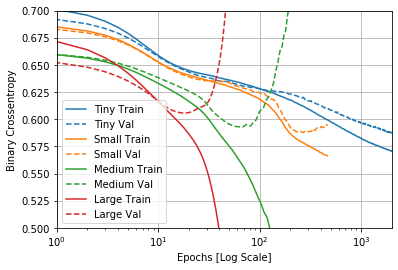

In [25]:
plotter.plot(sizeHistories)
a = plt.xscale('log')
plt.xlim([0, max(plt.xlim())])
plt.ylim([0.5, 0.7])
plt.xlabel('Epochs [Log Scale]')


#**Strategies to prevent overfitting**
Before getting into the content of this section copy the training logs from the "Tiny" model above, to use as a beseline for comparison.

In [26]:
shutil.rmtree(logdir/'regularizers/Tiny', ignore_errors=True)
shutil.copytree(logdir/'sizes/Tiny', logdir/'regularizers/Tiny')


PosixPath('/tmp/tmp5pv_cd_z/tensorboard_logs/regularizers/Tiny')

In [0]:
regularizerHistories = {}
regularizerHistories['Tiny'] = sizeHistories['Tiny']

#**Add weight regularization**
* You may be familiar with Occam's Razor principle: given two explanations for something, the explanation most likely to be correct is the "simplest" one, the one that makes the least amount of assumptions. This also applies to the models learned by neural networks: given some training data and a network architecture,there are multiple sets of weights values (multiple models) that could explain the data, and simpler models are less likely to overfit than complex ones.(or a model with fewer parameters altogether, as we saw in the section above). 
* Thus a common way to mitigate overfitting is to put constraints on the complexity of a network by forcing its weights only to take small values, which makes the distribution of weight values more "regular". This is called "weight regularization", and it is done by adding to the loss function of the network a cost associated with having large weights. This cost comes in two flavors:

> **L1(Laplacian) regularization**, where the cost added is proportional to the absolute value of the weights coefficients (i.e. to what is called the "L1 norm" of the weights).L1 regularization pushes weights towards exactly zero encouraging a sparse model.                   
>**L2(Gaussian) regularization**, where the cost added is proportional to the square of the value of the weights coefficients (i.e. to what is called the squared "L2 norm" of the weights). L2 regularization is also called weight decay in the context of neural networks. the weight decay is mathematically the exact same as L2 regularization.L2 regularization will penalize the weights parameters without making them sparse since the penalty goes to zero for small weights. one reason why L2 is more common.
*****************************************************************************
In tf.keras, weight regularization is added by passing weight regularizer instances to layers as keyword arguments. Let's add L2 weight regularization now.





In [28]:
l2Model = tf.keras.Sequential([
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001),
                 input_shape=(FEATURES,)),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(1, activation='sigmoid')
])
regularizerHistories['l2'] = compileAndFit(l2Model, "regularizers/l2")

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 512)               14848     
_________________________________________________________________
dense_15 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_16 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_17 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 513       
Total params: 803,329
Trainable params: 803,329
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.5102,  binary_crossentropy:0.8347,  loss:2.3587,  val_accuracy:0.5820,  val_binary_crossentr

**Binary crossentropy** is a loss function used on problems involving yes/no (binary) decisions. For instance, in multi-label problems, where an example can belong to multiple classes at the same time, the model tries to decide for each class whether the example belongs to that class or not.

Binary crossentropy measures how far away from the true value (which is either 0 or 1) the prediction is for each of the classes and then averages these class-wise errors to obtain the final loss.

* **L2 (0.001)**  means that every coefficient in the weight matrix of the layer will add **(0.001 x weight_coefficient_value ^ 2)** to the total loss of the network.
* That is why we're monitoring the binary_crossentropy directly. Because it doesn't have this regularization component mixed in.

* So, that same "Large" model with an L2 regularization penalty performs much better:

(0.5, 0.7)

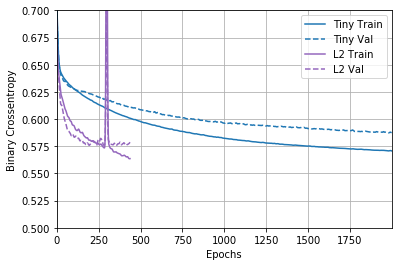

In [29]:
plotter.plot(regularizerHistories)
plt.ylim([0.5, 0.7])

As you can see, the "L2" regularized model is now much more competitive with the the "Tiny" model. This "L2" model is also much more resistant to overfitting than the "Large" model it was based on despite having a the same number of parameters.
* There are two important things to note about this sort of regularization.

> First: If you are writing your own training loop, then you need to be sure to ask the model for it's regularization losses.






In [0]:
result = l2Model(features)
regularizationLoss = tf.add_n(l2Model.losses)



> Second: This implementation works by adding the weight penalties to the model's loss, and then applying a standard optimization procedure after that.



#**Add Dropout**
The intuitive explaination for dropout is that because individual nodes in the network cannot rely on the output of the others, each node must output features that are useful on their own.


Dropout, applied to a layer, consists of randomly "dropping out" (i.e. set to zero) a number of output features of the layer during training. Let's say a given layer would normally have returned a vector [0.2, 0.5, 1.3, 0.8, 1.1] for a given input sample during training; after applying dropout, this vector will have a few zero entries distributed at random, e.g. [0, 0.5, 1.3, 0, 1.1].


At test time, no units are dropped out, and instead the layer's output values are scaled down by a factor equal to the dropout rate, so as to balance for the fact that more units are active than at training time.

> In tf.keras you can introduce dropout in a network via the Dropout layer, which gets applied to the output of layer right before.

* Let's add two Dropout layers in our network to see how well they do at reducing overfitting:

In [31]:
dropoutModel = tf.keras.Sequential([
    layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')])
regularizerHistories['Dropout'] = compileAndFit(dropoutModel, 'regularizers/dropout')

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 512)               14848     
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 512)              

![alt text](https://s3-ap-south-1.amazonaws.com/av-blog-media/wp-content/uploads/2017/05/20073927/dropout.png)

(0.5, 0.7)

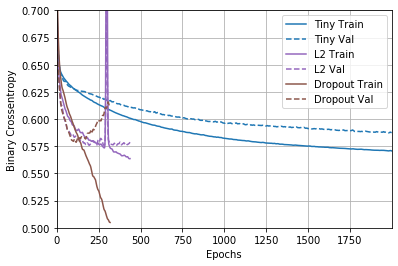

In [32]:
plotter.plot(regularizerHistories)
plt.ylim([0.5, 0.7])

It's clear from this plot that both of these regularization approaches improve teh behavior of the "Large" model. But this still doesn't beat even the "Tiny" baseline.
* Then let's try the two together and see if it's better.

#**Combined L2 + dropout**

In [33]:
combinedModel = tf.keras.Sequential([
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu', input_shape=(FEATURES,)),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')])
regularizerHistories['Combined'] = compileAndFit(combinedModel, 'regularizers/combined')

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 512)               14848     
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 512)              

(0.5, 0.7)

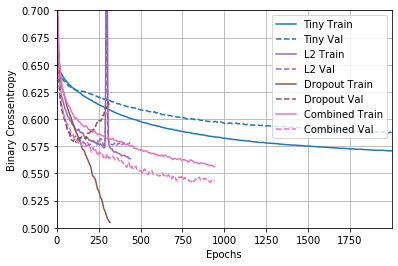

In [34]:
plotter.plot(regularizerHistories)
plt.ylim([0.5, 0.7])

#**As a result**
To recap: here are the most common ways to prevent overfitting in neural networks:
  * Get more training data.
  * Reduce the capacity of the network.
  * Add weight regularization.
  * Add dropout.


Two important approaches not covered in this guide are:
* Data-augmentation
* Batch normalization


Remember that each method can help on its own, but often combining them can be even more effective.

#**The End of today's code**